# DDoS PySpark Project

### Distributed Denial of Service (DDoS) Dataset

-   Scott Koskoski


### Abstract

This project uses a dataset created for DDOS Anomaly prediction. The Canadian Institute for Cybersecurity gathered the dataset using CICFlowMeter-V3, an open-source tool that generates Biflows from pcap files and extracts features from these flows. This packet data is from multiple devices with a mix of DDoS and benign data gathered from Friday afternoon working hours. The dataset has 225,746 rows and contains up to 85 columns or different features. The main features include source IPs, source ports, destination IPs, destination ports, protocols, flow duration, total forwarded packages, and total backward packages, as well as metrics to predict the duration of trips. The approach is to clean the data and utilize feature extraction to find the best features to determine when there is an anomaly in your network traffic. We use different ML algorithms to train and test the detection of attacks. This analysis approaches this as a classification problem since it aims to predict whether you are subject to a DDOS attack. The dataset is open source and available at Kaggle.


## Stage 1: Reading and Exploring Data


In [1]:
import zipfile
import os

current_dir = os.getcwd()

zip_file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.zip"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(current_dir)
zip_file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.zip"
print(f"Unzipped {zip_file_path} to {current_dir}.")

Unzipped Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.zip to /workspace.


In [2]:
from pyspark.sql import SparkSession

# Creating SparkSession
spark = (
    SparkSession.builder.appName("DDoS Kaggle Project")
    .getOrCreate()
)

# Loading CSV file into Spark DataFrame
dataset_file = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

df = spark.read.csv(
    dataset_file,
    header=True,
    inferSchema=True
)

df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/18 20:02:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/18 20:02:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------+------------+---------------+-----------------+---------+-------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+-

25/01/18 20:02:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Fla

In [3]:
# Counting number of rows
print(f"Number of rows: {df.count()}")

# Checking data schema
df.printSchema()

Number of rows: 225745
root
 |-- Flow ID: string (nullable = true)
 |--  Source IP: string (nullable = true)
 |--  Source Port: integer (nullable = true)
 |--  Destination IP: string (nullable = true)
 |--  Destination Port: integer (nullable = true)
 |--  Protocol: integer (nullable = true)
 |--  Timestamp: string (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  B

In [4]:
rdd = spark.sparkContext.parallelize([1])
print(rdd.map(lambda _: __import__("sys").executable).collect())


[Stage 6:>                                                        (0 + 16) / 16]

['/usr/local/bin/python3']


In [5]:
# Removing annoying spaces from column names
df = df.toDF(*[col.strip().replace(" ", "_") for col in df.columns])

print(df.columns)

['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Timestamp', 'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes/s', 'Flow_Packets/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length40', 'Bwd_Header_Length', 'Fwd_Packets/s', 'Bwd_Packets/s', 'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean', 'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count', 'SYN_Flag_Count', 'RST_Flag_Count', 'PS

In [6]:
# Viewing labels and counts
label_counts = df.groupBy("Label").count()

label_counts.show()

[Stage 7:===>                                                     (1 + 15) / 16]

+------+------+
| Label| count|
+------+------+
|BENIGN| 97718|
|  DDoS|128027|
+------+------+



In [7]:
# DataFrame summary statistics
df.summary().show()

25/01/18 20:02:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Fla

+-------+--------------------+-------------+-----------------+--------------+-----------------+------------------+-------------+--------------------+------------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+------------------+-----------------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+-----------------+------------------+--------------------+------------------+-------------------+-------------+-------------+-------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+--------------------+--------------

In [8]:
# Checking for missing values
from pyspark.sql.functions import col, sum

# Calculating missing values
missing_values = df.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in df.columns]
)

# Converting to a DataFrame with column names and counts
missing_counts = missing_values.collect()[0].asDict()

# Converting to PySpark DataFrame for ordering
missing_df = spark.createDataFrame(
    [(col_name, missing_counts[col_name]) for col_name in df.columns],
    ["Column", "Missing"]
)

# Ordering by missing values descending
missing_df = missing_df.orderBy("Missing", ascending=False)

missing_df.show()

25/01/18 20:02:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Fla

+--------------------+-------+
|              Column|Missing|
+--------------------+-------+
| Fwd_Header_Length40|      0|
|Total_Length_of_F...|      0|
|         Bwd_IAT_Min|      0|
|Total_Length_of_B...|      0|
|min_seg_size_forward|      0|
|Fwd_Packet_Length...|      0|
|       Fwd_PSH_Flags|      0|
|Fwd_Packet_Length...|      0|
|   Max_Packet_Length|      0|
|Fwd_Packet_Length...|      0|
|       Bwd_PSH_Flags|      0|
|         Active_Mean|      0|
|       Fwd_URG_Flags|      0|
|Fwd_Packet_Length...|      0|
|       Bwd_URG_Flags|      0|
|          Active_Std|      0|
|  Packet_Length_Mean|      0|
|          Active_Max|      0|
|             Flow_ID|      0|
|          Active_Min|      0|
+--------------------+-------+
only showing top 20 rows



In [9]:

rdd = spark.sparkContext.parallelize([1])
print(rdd.map(lambda _: __import__("sys").executable).collect())


['/usr/local/bin/python3']


25/01/18 20:02:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header:  Source Port,  Destination Port,  Protocol,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Flag Count,  RST Flag Count,  PSH Flag Count,  ACK Fl

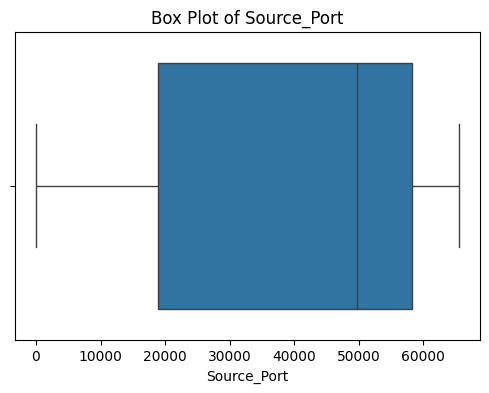

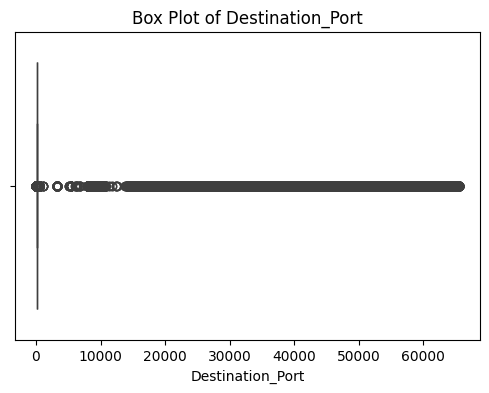

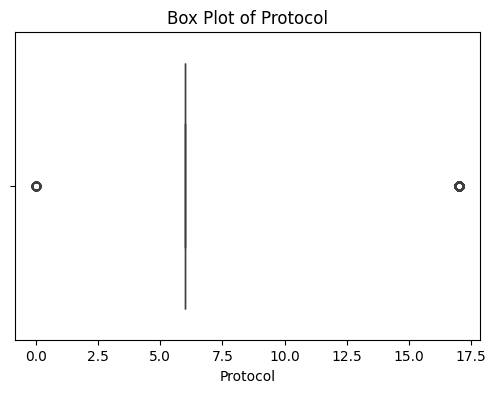

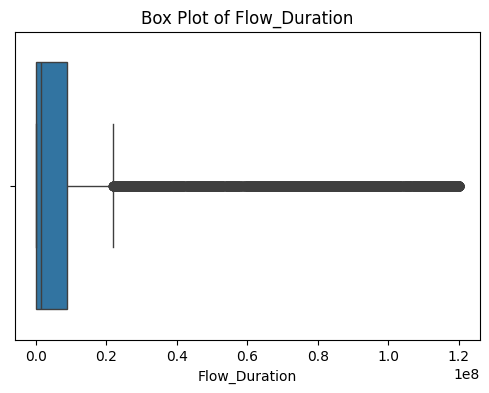

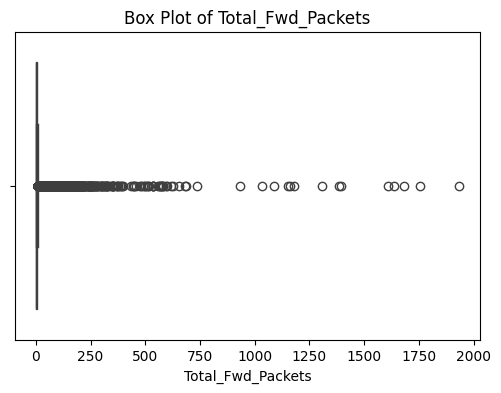

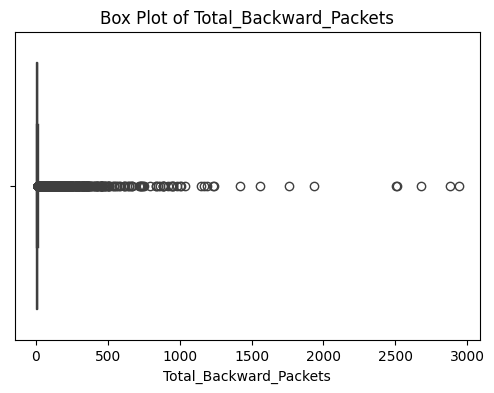

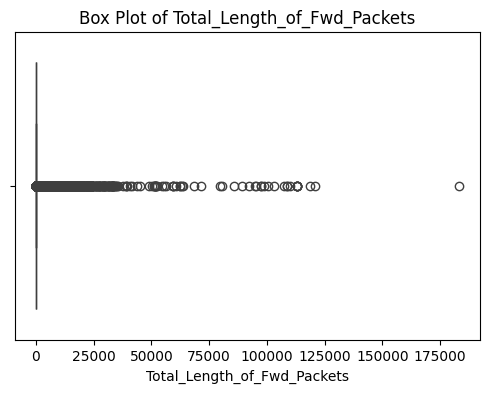

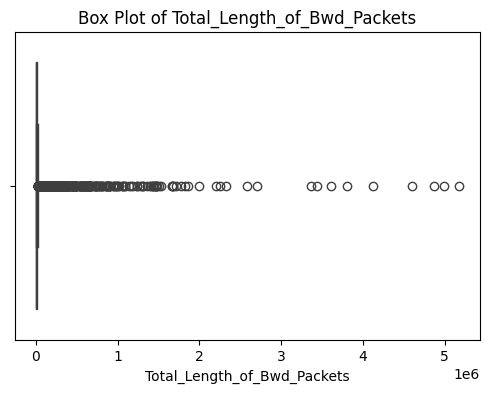

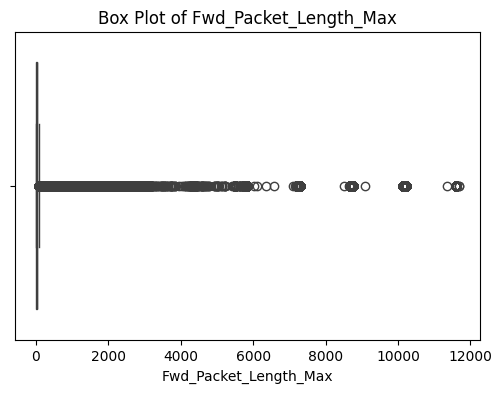

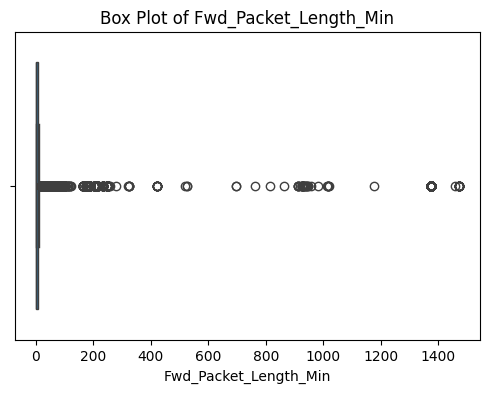

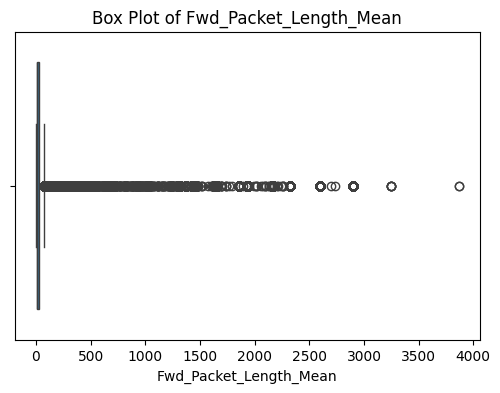

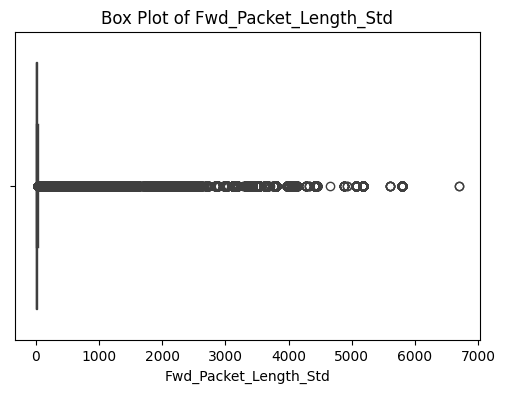

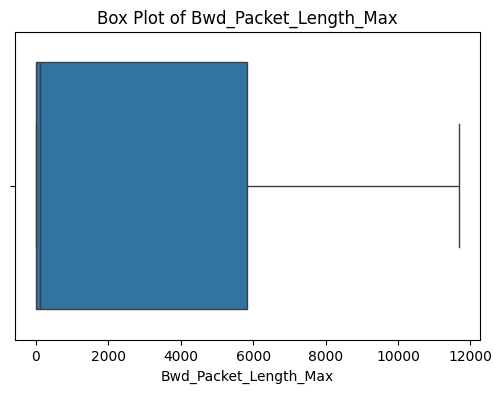

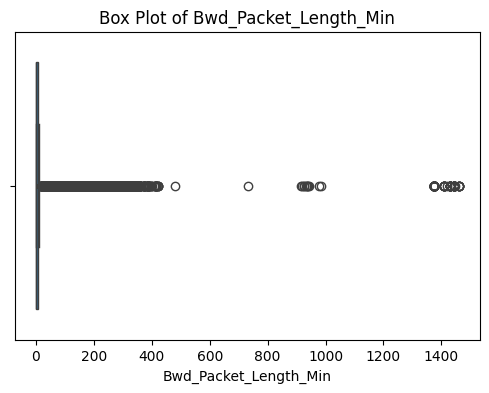

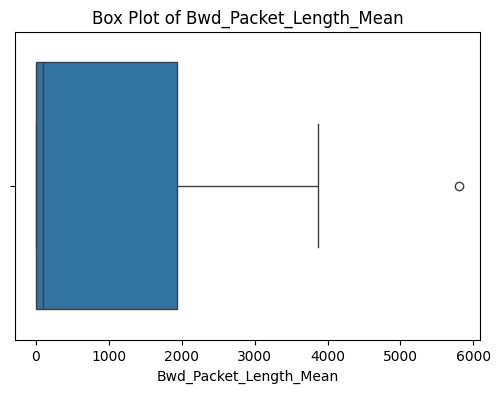

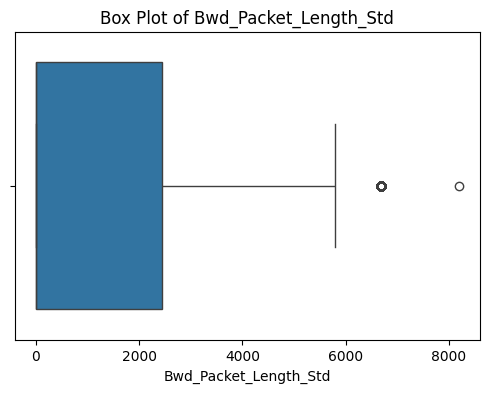

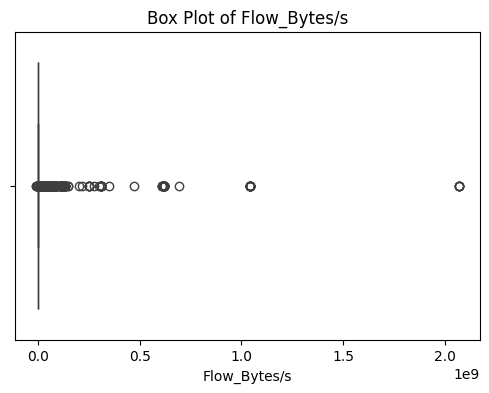

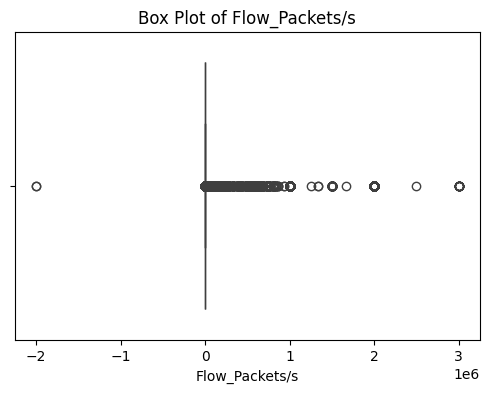

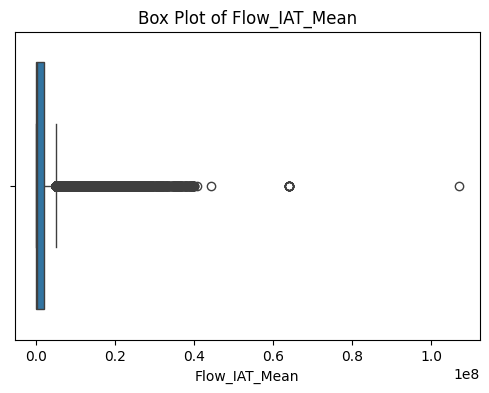

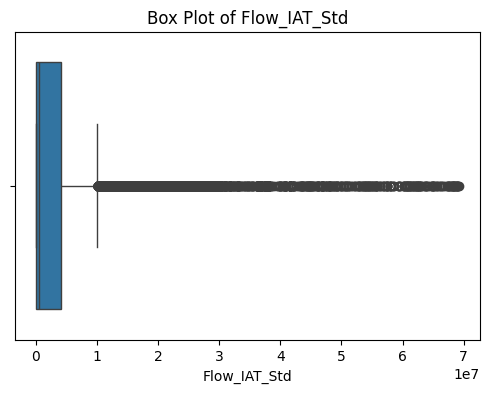

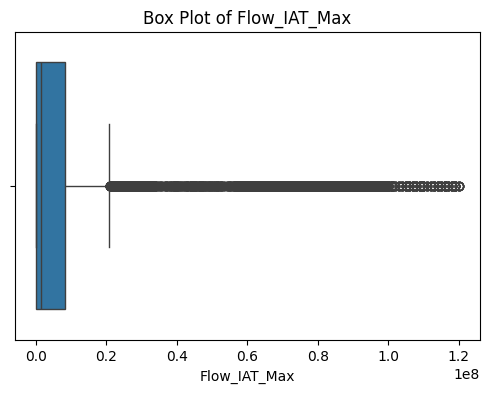

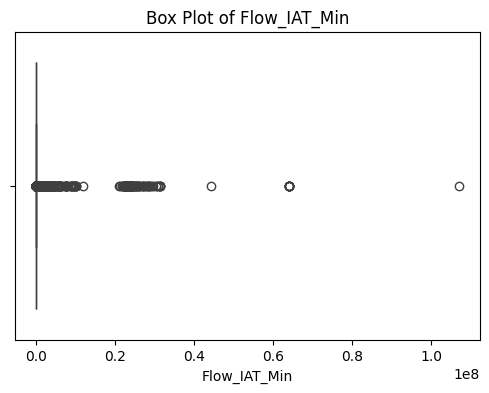

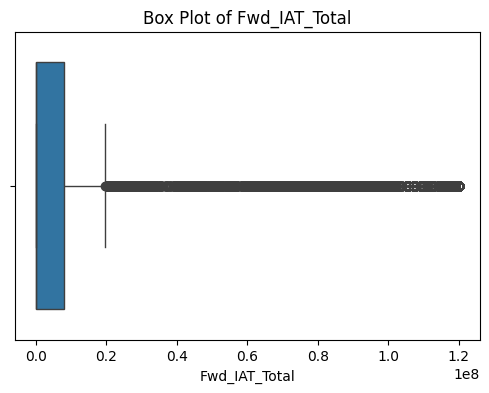

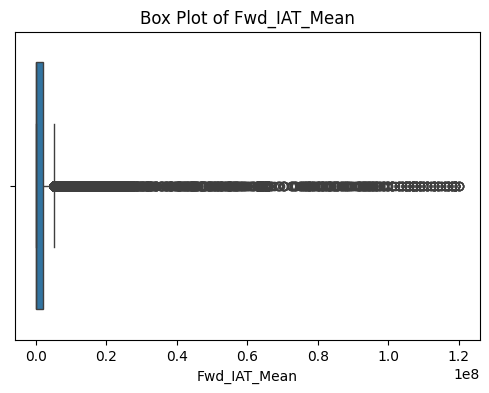

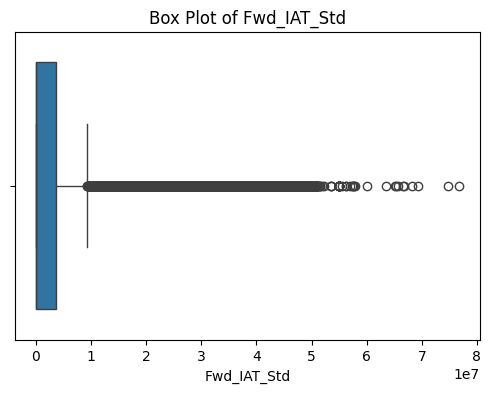

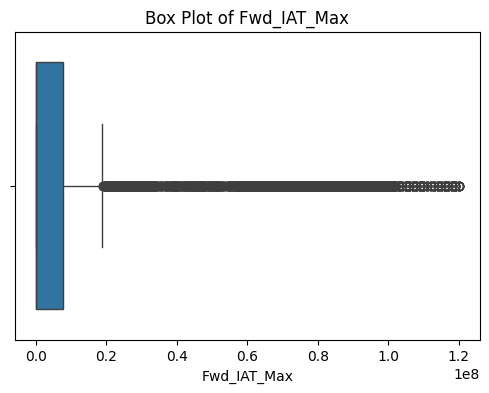

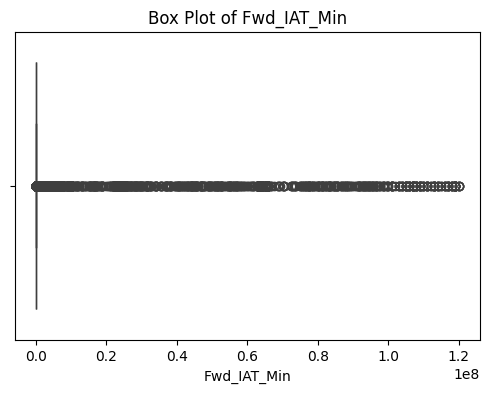

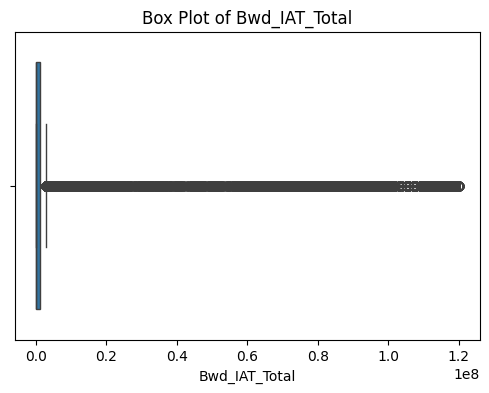

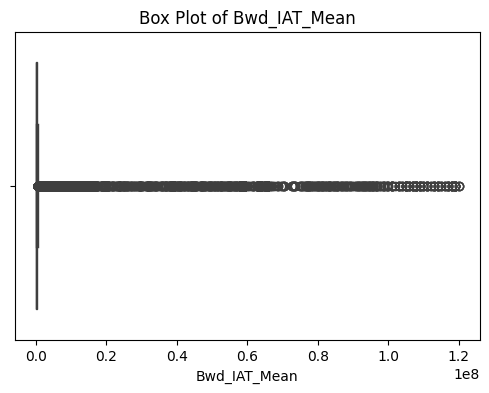

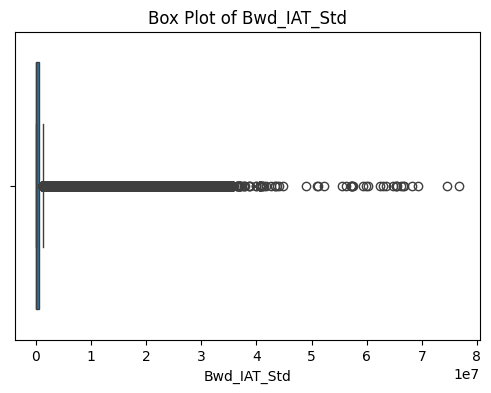

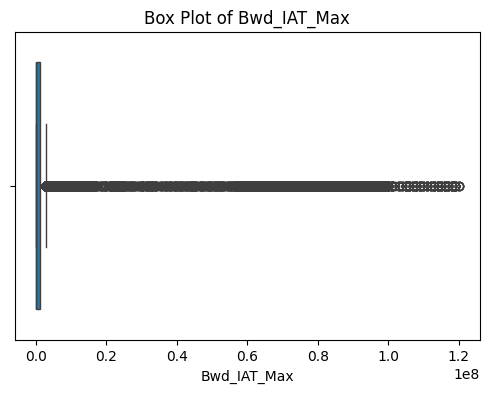

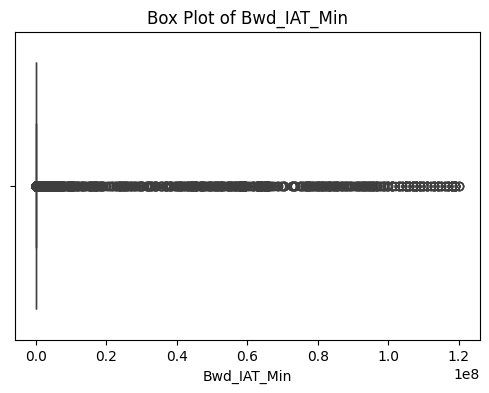

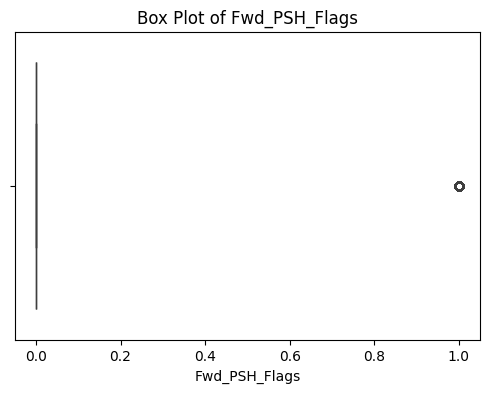

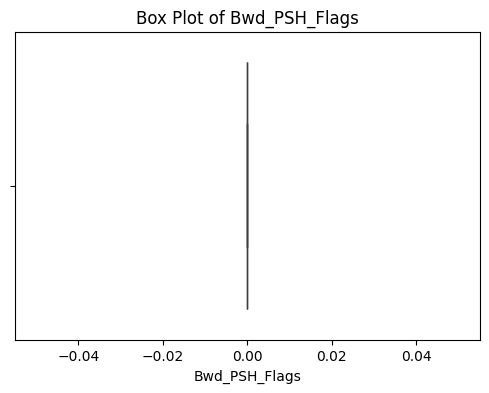

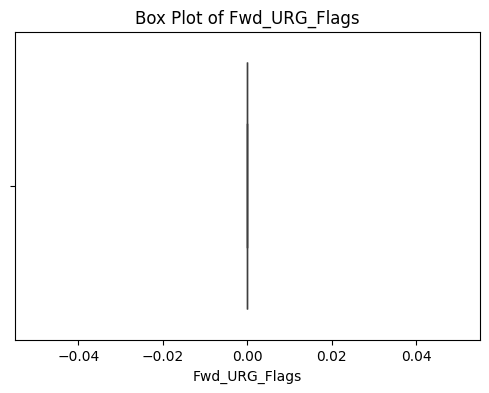

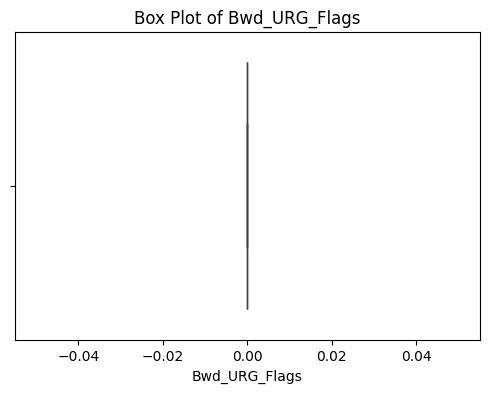

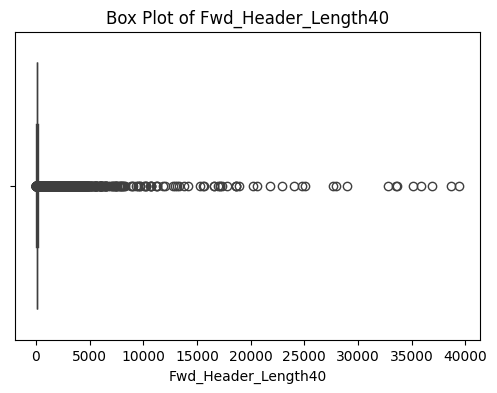

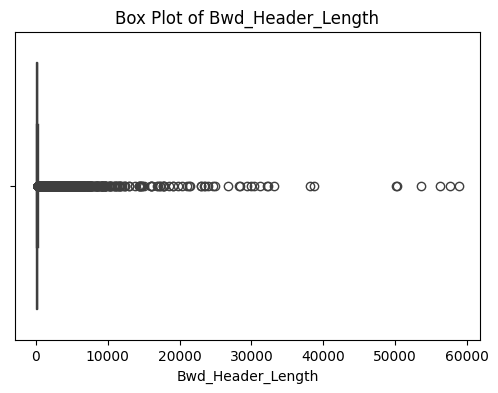

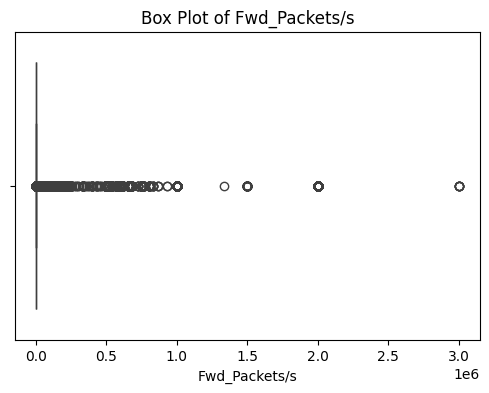

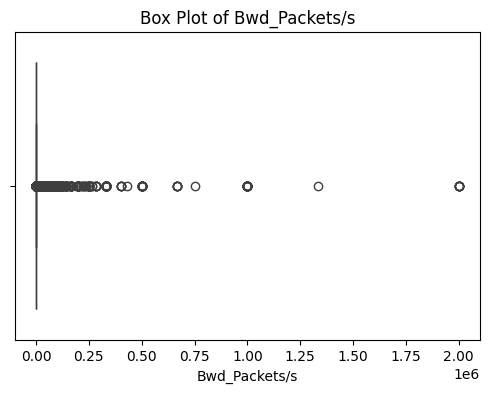

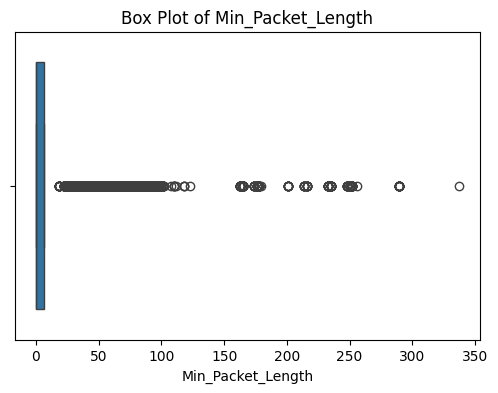

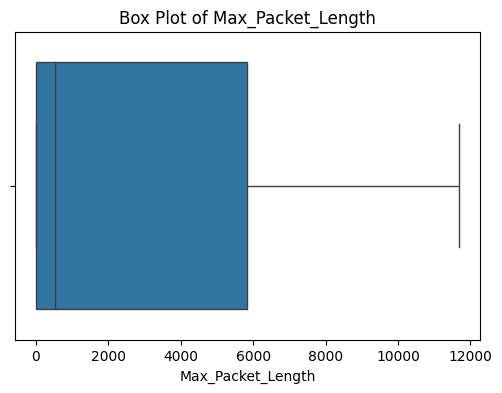

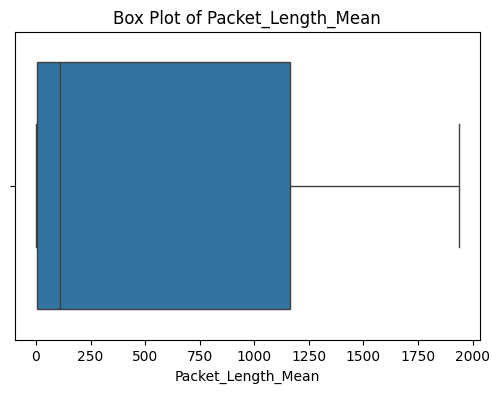

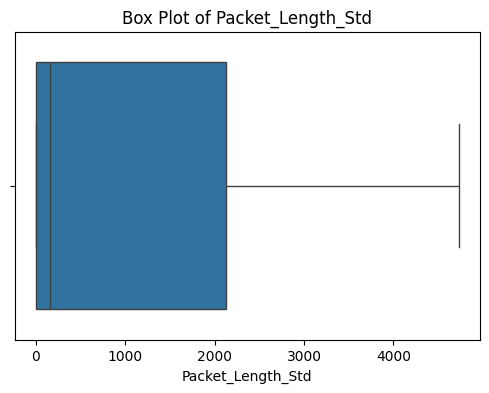

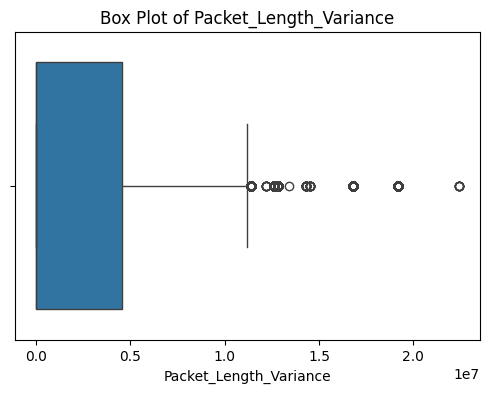

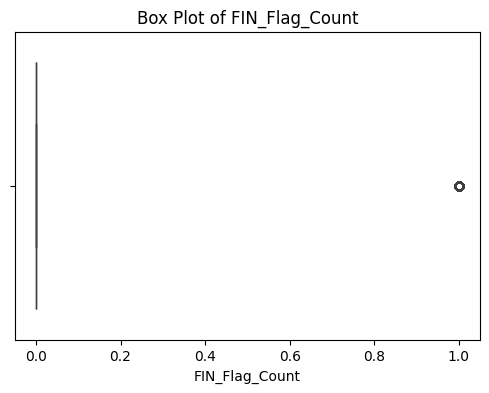

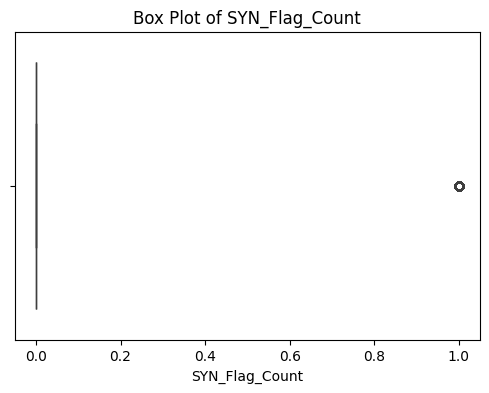

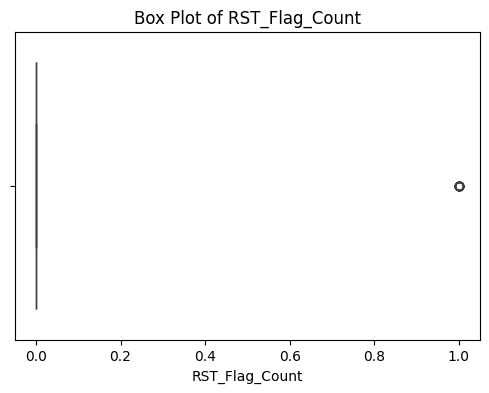

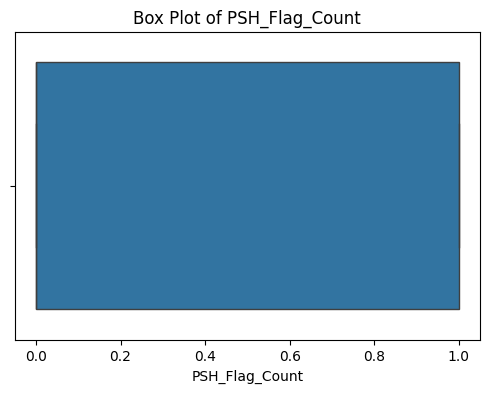

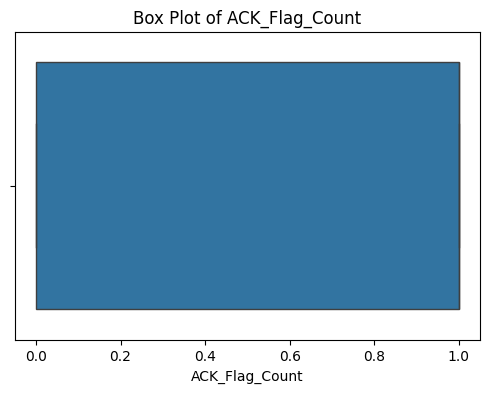

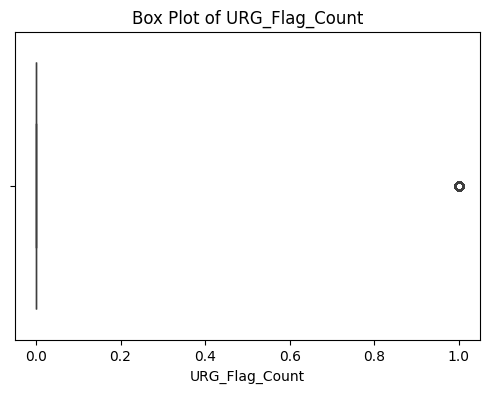

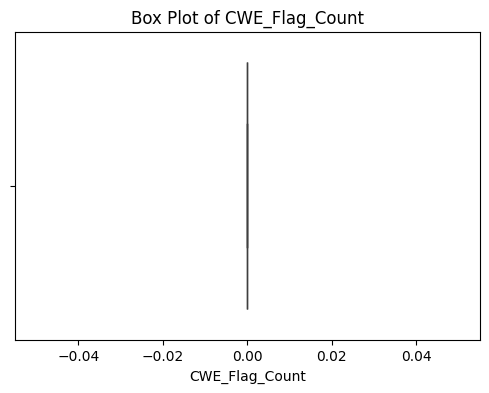

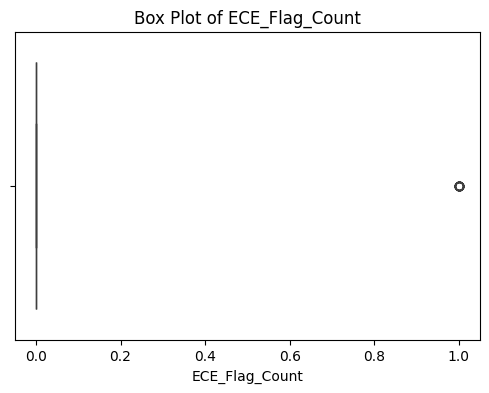

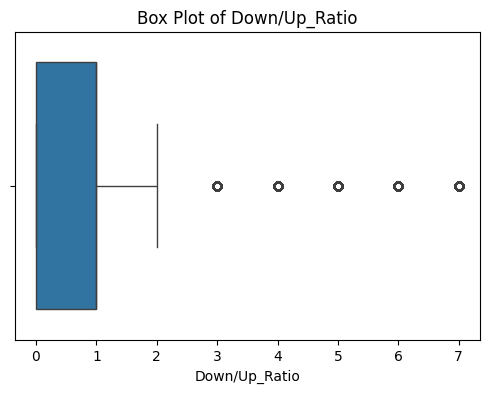

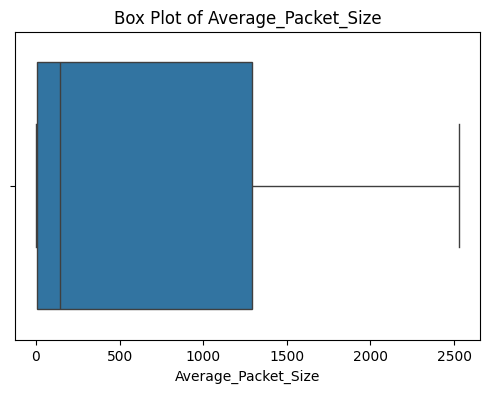

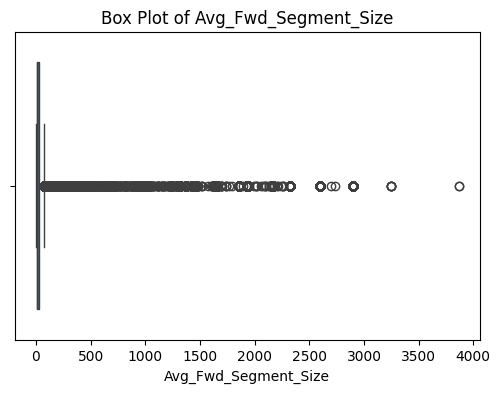

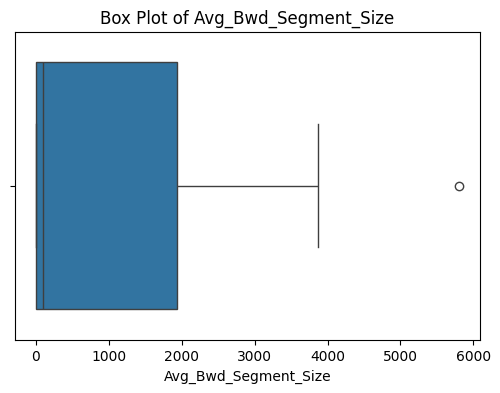

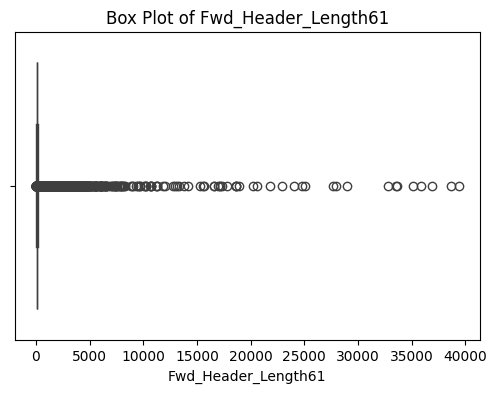

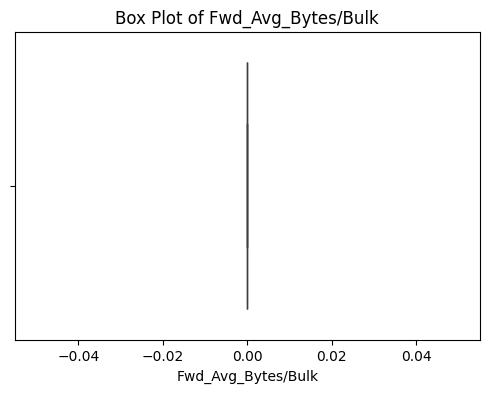

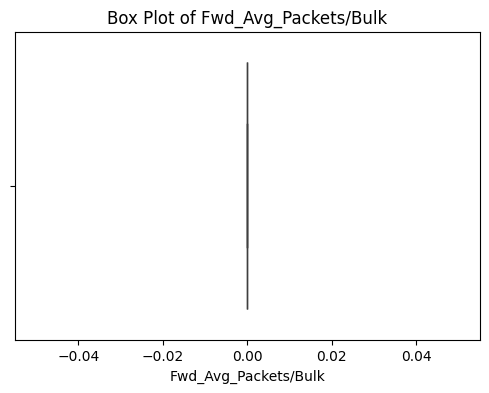

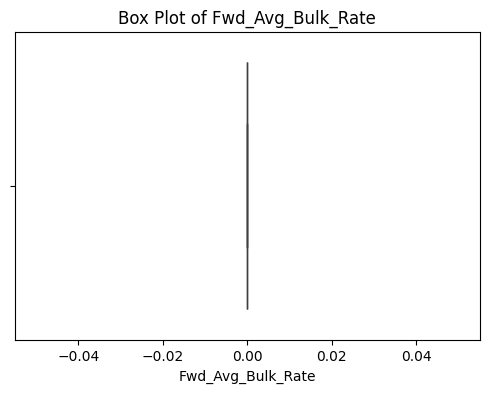

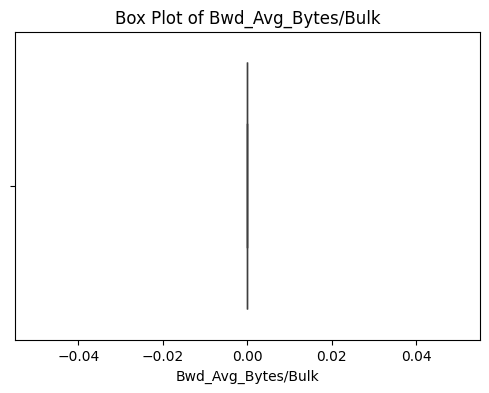

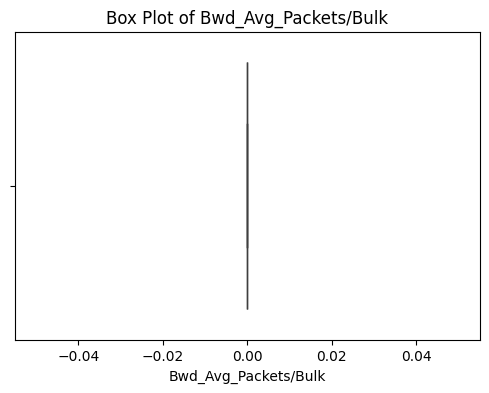

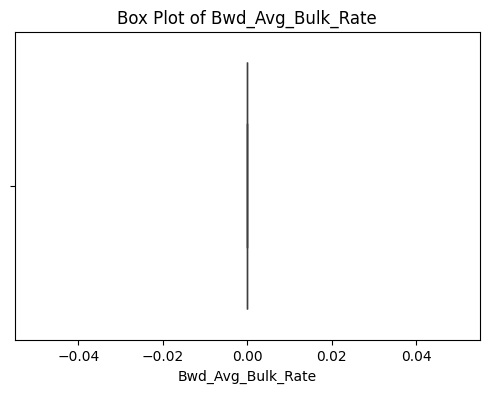

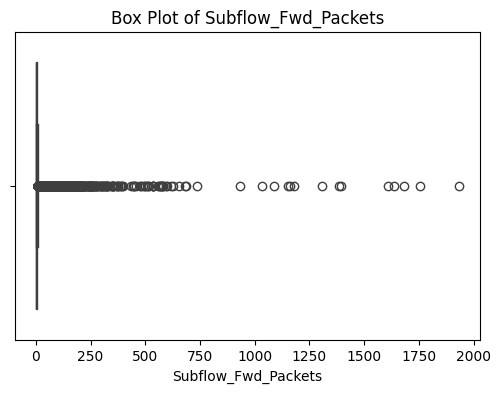

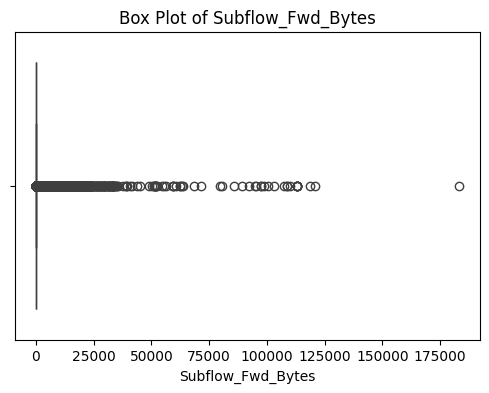

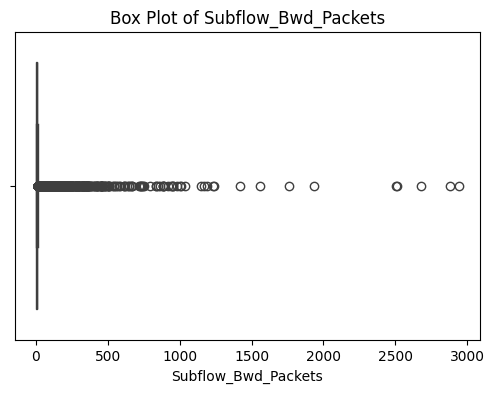

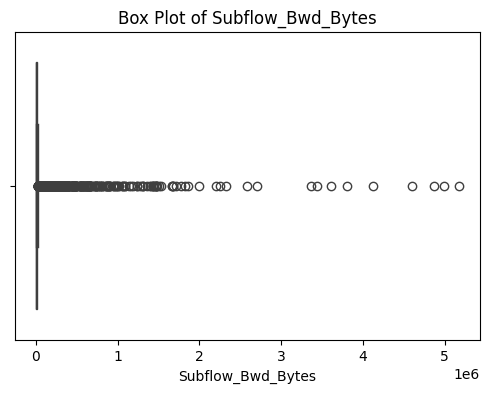

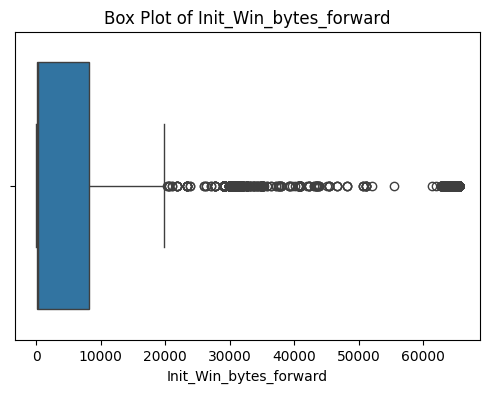

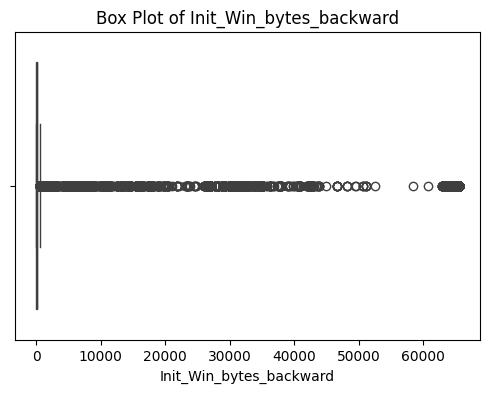

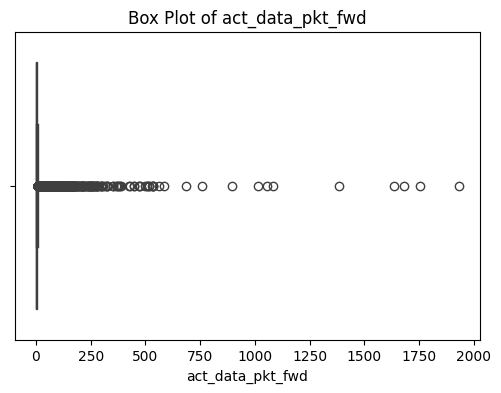

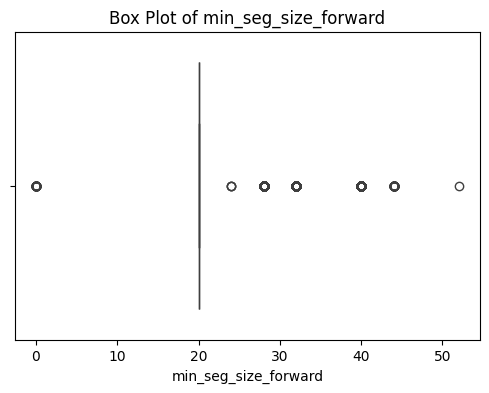

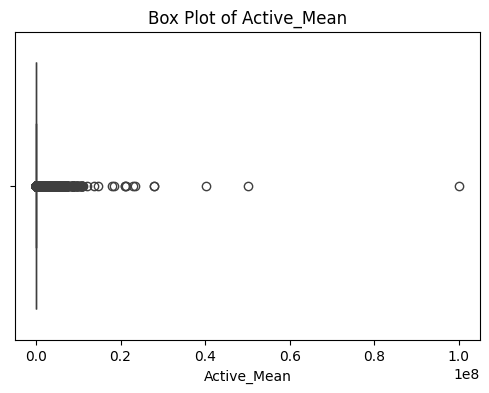

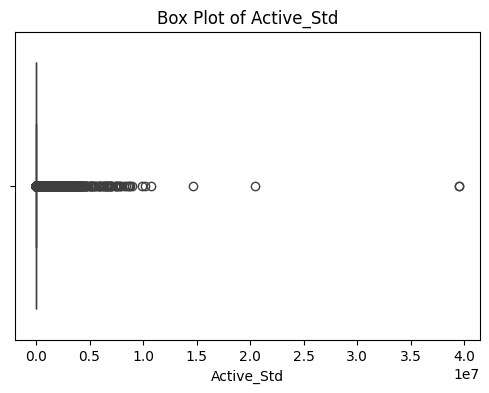

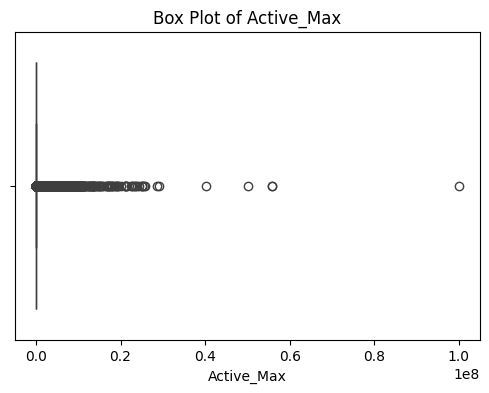

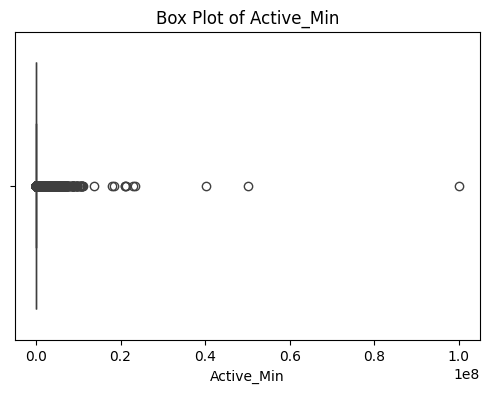

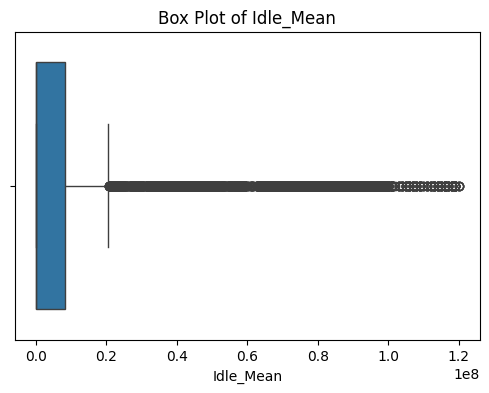

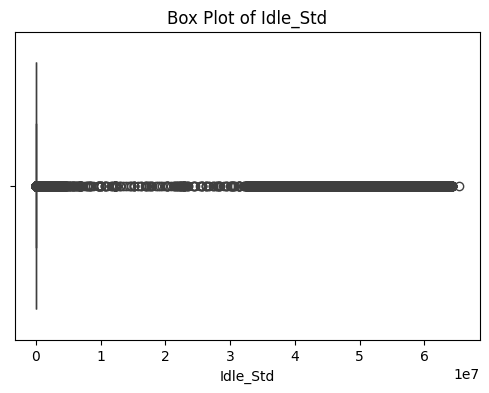

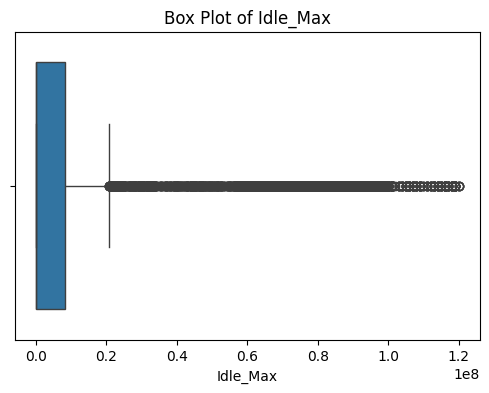

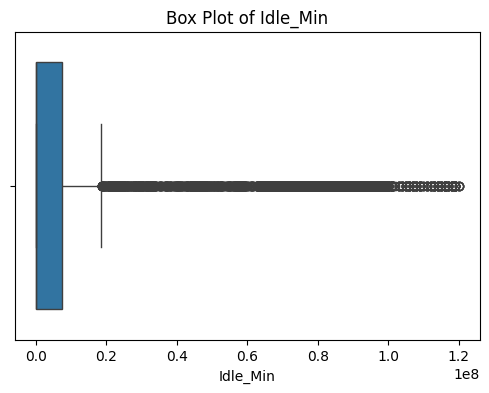

In [10]:
# Box Plots of Numeric Variables

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import NumericType

# Identifying numeric columns
numeric_cols = [col[0] for col in df.dtypes if isinstance(df.schema[col[0]].dataType, NumericType)]

# Converting the DataFrame to Pandas for visualization
df_pandas = df.select(numeric_cols).toPandas()

# Plotting box plots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_pandas, x=col)
    plt.title(f'Box Plot of {col}')
    plt.show()


## Stage 2: Cleansing Data and Feature Engineering


In [11]:
# Excluding our ID, Label, and irrelevant columns
# Existing Kaggle code helped determine these
columns_to_exclude = [
    # Identifiers and Metadata
    "Flow_ID", "Source_IP", "Destination_IP", "Source_Port", "Destination_Port", "Timestamp",

    # Flags and Counters
    "Fwd_PSH_Flags", "Bwd_PSH_Flags", "Fwd_URG_Flags", "Bwd_URG_Flags",
    "FIN_Flag_Count", "SYN_Flag_Count", "RST_Flag_Count",
    "PSH_Flag_Count", "ACK_Flag_Count", "URG_Flag_Count",
    "CWE_Flag_Count", "ECE_Flag_Count",

    # Redundant or Derived Features
    "Flow_Bytes/s", "Flow_Packets/s", "Fwd_Packets/s", "Bwd_Packets/s",
    "Fwd_Header_Length40", "Fwd_Header_Length61",
    "Packet_Length_Variance",

    # Bulk Statistics
    "Fwd_Avg_Bytes/Bulk", "Fwd_Avg_Packets/Bulk", "Fwd_Avg_Bulk_Rate",
    "Bwd_Avg_Bytes/Bulk", "Bwd_Avg_Packets/Bulk", "Bwd_Avg_Bulk_Rate",

    # Noisy or Ambiguous Features
    "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd",
    "min_seg_size_forward",

    # Statistical Redundancy and Miscellaneous
    "Bwd_Header_Length", "Avg_Fwd_Segment_Size", "Avg_Bwd_Segment_Size",
    "Down/Up_Ratio", "Active_Std", "Active_Min", "Idle_Std", "Idle_Min",

    # Target Column
    "Label"
]

In [12]:
# Evaluating correlation of feature columns with Label
from pyspark.sql.functions import col, when

label_numeric_mapping = when(col("Label") == "BENIGN", 0).otherwise(1)

# Selecting numeric columns (excluding excluded columns and ensuring numeric types)
numeric_cols = [
    column for column, dtype in df.dtypes
    if column not in columns_to_exclude and dtype in ["int", "double", "float"]
]

# Computing correlations
correlations = {}
for column in numeric_cols:
    corr_value = df.select(col(column).alias("feature"), label_numeric_mapping.alias("Label_numeric")) \
                   .stat.corr("feature", "Label_numeric")
    correlations[column] = corr_value

# Sorting by absolute correlation
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Displaying top correlated columns
print("Top features correlated with Label:")
for column, corr in sorted_correlations[:10]:
    print(f"{column}: {corr}")


Top features correlated with Label:
Bwd_Packet_Length_Mean: 0.6032991997727765
Bwd_Packet_Length_Max: 0.5773234966964609
Bwd_Packet_Length_Std: 0.5761548465077597
Protocol: -0.4719036675769311
Packet_Length_Mean: 0.4542833973523457
Average_Packet_Size: 0.4534721764753985
Packet_Length_Std: 0.44374925973818025
Min_Packet_Length: -0.42739634447482455
Max_Packet_Length: 0.41439887065891706
Bwd_Packet_Length_Min: -0.3656674463241358


In [13]:
# Filtering out outliers
from pyspark.sql.functions import col

numeric_cols_to_process = [col for col in numeric_cols if col not in columns_to_exclude]

df_outliers_removed = df

# Process each numeric column and remove outliers based on IQR
for column in numeric_cols_to_process:
    Q1, Q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter rows within the bounds for the current column
    df_outliers_removed = df_outliers_removed.filter(
        (col(column) >= lower_bound) & (col(column) <= upper_bound)
    )

original_row_count = df.count()
final_row_count = df_outliers_removed.count()

print(f"Dataset row count after outlier removal: {final_row_count}")
print(f"Percentage of rows removed: {((original_row_count - final_row_count) / original_row_count) * 100:.2f}%")

[Stage 227:=================>                                     (5 + 11) / 16]

Dataset row count after outlier removal: 69447
Percentage of rows removed: 69.24%


Outliers were found in 67% of rows, so that is too many rows to remove. Going forward with full data.


In [14]:
# One-Hot Encoding for Categorical Variables
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Identifying categorical columns
categorical_columns = [
    col[0] for col in df.dtypes if col[1] == "string" and col[0] not in columns_to_exclude
]

# Creating StringIndexer and OneHotEncoder stages for categorical columns
indexers = [StringIndexer(inputCol=col,
                          outputCol=f"{col}_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_index",
                          outputCol=f"{col}_encoded") for col in categorical_columns]


# Building pipeline
encoding_pipeline = Pipeline(stages=indexers + encoders)

df_encoded = encoding_pipeline.fit(df).transform(df)

# Dropping intermediate columns
columns_to_drop = [f"{col}_index" for col in categorical_columns]
df_encoded = df_encoded.drop(*columns_to_drop)

df_encoded.show()

25/01/18 20:03:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Fla

+--------------------+--------------+-----------+--------------+----------------+--------+-------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+-------

In [15]:
# Scaling Numerical Features
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# First replacing Infinity avalues with 0
df_encoded = df_encoded.replace(
    [float("inf"), float("-inf")], 0, subset=["Flow_Bytes/s", "Flow_Packets/s"]
)

# Handling missing values
numerical_columns = [
    col[0]
    for col in df_encoded.dtypes
    if col[1] in ("int", "double") and col[0] not in columns_to_exclude
]

df_encoded = df_encoded.na.fill(value=0, subset=numerical_columns)

# Combining numerical columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol="numerical_features"
)

# Applying StandardScaler to feature vector
scaler = StandardScaler(
    inputCol="numerical_features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

# Building scaling pipeline
scaling_pipeline = Pipeline(stages=[assembler, scaler])

# Fitting and transforming data
df_scaled = scaling_pipeline.fit(df_encoded).transform(df_encoded)

# scaled_features column contains all scaled numeric featuers as a single vector
df_scaled.select("scaled_features").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                 

In [16]:
### Creating final DataFrame for modeling

# Mapping "BENIGN" to 0 and "DDoS" to 1 in the Label column
df_scaled = df_scaled.withColumn(
    "Label_transformed",
    when(df_scaled["Label"] == "BENIGN", 0).when(df_scaled["Label"] == "DDoS", 1).otherwise(None)
)

# Combining numerical and encoded columns into a single feature vector

one_hot_encoded_columns = [col for col in df_encoded.columns if "encoded" in col]

final_assembler = VectorAssembler(
    inputCols=["scaled_features"] + one_hot_encoded_columns,
    outputCol="final_features"
)

final_pipeline = Pipeline(stages=[final_assembler])

df_combined = final_pipeline.fit(df_scaled).transform(df_scaled)

# Retain Flow_ID (index), Label_transformed (target), and final_features (input for machine learning)
df_final = df_combined.select("Flow_ID", "Label_transformed", "final_features")

# Show the final DataFrame
df_final.show(truncate=False)

+---------------------------------------+-----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Flow_ID                                |Label_transformed|final_features                              

## Stage 3: Machine Learning


#### Train/Test Split


In [17]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=69)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 180489


[Stage 239:===>                                                   (1 + 15) / 16]

Test Data Count: 45256


We will use Recall as our primary metric for evaluating our models because false negatives can be highly detrimental. We want to ensure that we are catching all DDoS attacks.


#### Logistic Regression Baseline


In [18]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when, count

# Defining Logistic Regression model
lr = LogisticRegression(
    featuresCol="final_features",
    labelCol="Label_transformed"
)

# Training LR model
lr_model = lr.fit(train_data)

# Making predictions on test data
predictions = lr_model.transform(test_data)

# Evaluating ROC-AUC
roc_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = roc_auc_evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

# Evaluating Precision and Recall
tp = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Evaluating Accuracy
accuracy = predictions.filter(col("Label_transformed") == col("prediction")).count() / predictions.count()
print(f"Accuracy: {accuracy:.4f}")


25/01/18 20:03:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/18 20:03:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

ROC-AUC: 0.9995


Precision: 0.9987
Recall (Sensitivity): 0.9987
F1-Score: 0.9987


Accuracy: 0.9985


#### Random Forest


In [19]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Defining Random Forest model
rf = RandomForestClassifier(
    featuresCol="final_features",
    labelCol="Label_transformed",
    numTrees=100,  # You can adjust this parameter as needed
    maxDepth=10     # You can also tune this parameter
)

# Training RF model
rf_model = rf.fit(train_data)

# Making predictions on test data
predictions = rf_model.transform(test_data)

# Evaluating ROC-AUC
roc_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = roc_auc_evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

# Evaluating Precision and Recall
tp = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Evaluating Accuracy
accuracy = predictions.filter(col("Label_transformed") == col("prediction")).count() / predictions.count()
print(f"Accuracy: {accuracy:.4f}")


25/01/18 20:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB
25/01/18 20:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1347.2 KiB
25/01/18 20:04:10 WARN DAGScheduler: Broadcasting large task binary with size 1642.9 KiB
25/01/18 20:04:11 WARN DAGScheduler: Broadcasting large task binary with size 1106.8 KiB
                                                                                

ROC-AUC: 1.0000


25/01/18 20:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB
25/01/18 20:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB
25/01/18 20:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB
25/01/18 20:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1111.2 KiB


Precision: 1.0000
Recall (Sensitivity): 0.9991
F1-Score: 0.9995


Accuracy: 0.9995


#### Gradient-Boosted Trees


In [20]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Defining Gradient-Boosted Trees model
gbt = GBTClassifier(
    featuresCol="final_features",
    labelCol="Label_transformed",
    maxIter=100,  # Number of boosting iterations
    maxDepth=5    # Maximum depth of each tree
)

# Training GBT model
gbt_model = gbt.fit(train_data)

# Making predictions on test data
predictions = gbt_model.transform(test_data)

# Evaluating ROC-AUC
roc_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = roc_auc_evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

# Evaluating Precision and Recall
tp = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Evaluating Accuracy
accuracy = predictions.filter(col("Label_transformed") == col("prediction")).count() / predictions.count()
print(f"Accuracy: {accuracy:.4f}")


ROC-AUC: 0.9999


Precision: 1.0000
Recall (Sensitivity): 0.9990
F1-Score: 0.9995


Accuracy: 0.9994


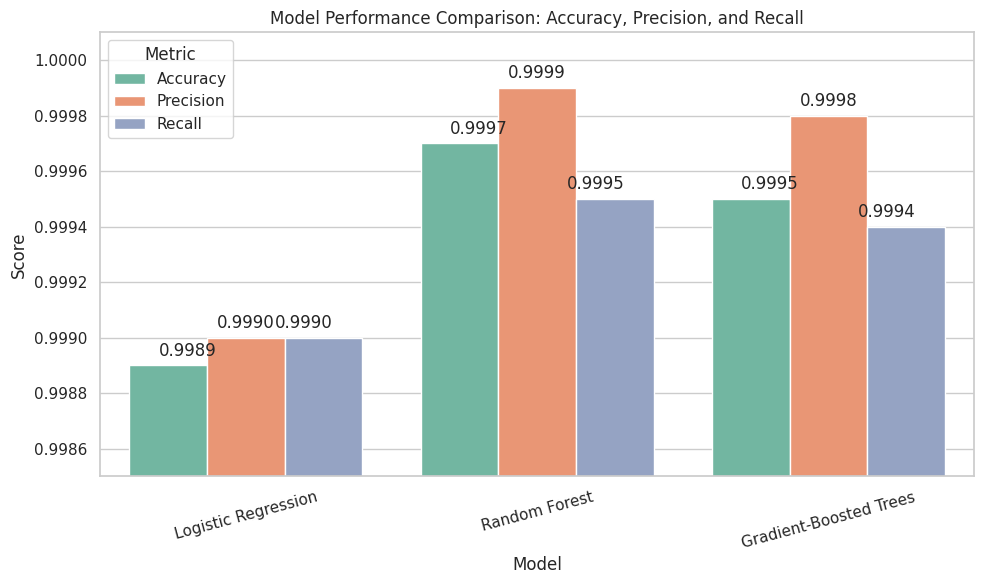

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Performance metrics for each model
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient-Boosted Trees'],
    'Accuracy': [0.9989, 0.9997, 0.9995],
    'Precision': [0.9990, 0.9999, 0.9998],
    'Recall': [0.9990, 0.9995, 0.9994]
}

# Create a DataFrame from metrics dictionary
df_metrics = pd.DataFrame(metrics)

# Melt the DataFrame for easier plotting with Seaborn
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set plot style
sns.set(style="whitegrid")

# Plot the bar chart with adjusted y-axis limits
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='Set2')

# Customize plot
plt.title('Model Performance Comparison: Accuracy, Precision, and Recall')
plt.ylabel('Score')
plt.ylim(0.9985, 1.0001)  # Adjust y-axis limits to zoom in on the differences
plt.xticks(rotation=15)
plt.legend(title='Metric')
plt.tight_layout()

# Add data labels to each bar
for index, row in df_melted.iterrows():
    plt.text(
        x=index % 3 - 0.2 + (index // 3) * 0.2,
        y=row['Score'] + 0.00002,
        s=f"{row['Score']:.4f}",
        ha='center',
        va='bottom'
    )

# Show plot
plt.show()

#### Random Forest Hyperparameter Tuning


Since Random Forest performed the best of the above models, we will now perform hyperparameter tuning to try to improve even further.


In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col

# Defining Random Forest model
rf = RandomForestClassifier(
    featuresCol="final_features",
    labelCol="Label_transformed"
)

# Defining parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [15, 25]) # number of trees
              .addGrid(rf.maxDepth, [12, 15]) # max depth of trees
              .addGrid(rf.maxBins, [8, 16]) # max number of bins
              .addGrid(rf.minInstancesPerNode, [1, 2]) # min instances each child must have after split
              .addGrid(rf.minInfoGain, [0.0, 0.01]) # min information gain for split
              .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt']) # proportion of features per split
              .build())

# Defining evaluator with Recall as the metric
recall_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"  # Proxy for recall-focused evaluation
)

# Cross-validation setup
cross_validator = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=recall_evaluator,
    numFolds=3  # 3-fold cross-validation
)

# Running cross-validation to find the best model
cv_model = cross_validator.fit(train_data)

# Getting the best model
best_rf_model = cv_model.bestModel

# Making predictions on the test data with the best model
predictions = best_rf_model.transform(test_data)

# Evaluating model metrics
roc_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = roc_auc_evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

# Calculating Precision, Recall, and F1-Score
tp = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Evaluating Accuracy
accuracy = predictions.filter(col("Label_transformed") == col("prediction")).count() / predictions.count()
print(f"Accuracy: {accuracy:.4f}")

# Best model's parameters
print("\nBest Model Parameters:")
print(f" - Number of Trees: {best_rf_model.getNumTrees}")
print(f" - Max Depth: {best_rf_model.getOrDefault('maxDepth')}")
print(f" - Max Bins: {best_rf_model.getOrDefault('maxBins')}")
print(f" - Min Instances Per Node: {best_rf_model.getOrDefault('minInstancesPerNode')}")
print(f" - Min Info Gain: {best_rf_model.getOrDefault('minInfoGain')}")
print(f" - Feature Subset Strategy: {best_rf_model.getOrDefault('featureSubsetStrategy')}")


ROC-AUC: 1.0000


Precision: 0.9999
Recall (Sensitivity): 0.9994
F1-Score: 0.9996


Accuracy: 0.9996

Best Model Parameters:
 - Number of Trees: 15
 - Max Depth: 15
 - Max Bins: 8
 - Min Instances Per Node: 1
 - Min Info Gain: 0.0
 - Feature Subset Strategy: auto


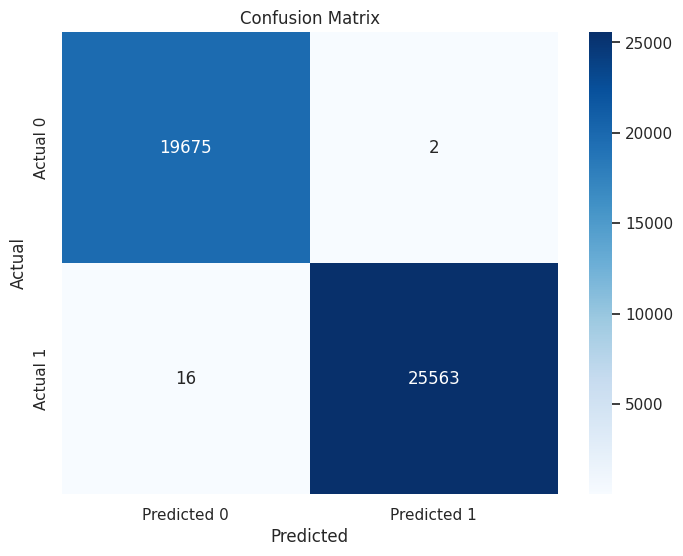

In [23]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Calculating confusion matrix components
tp = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()
tn = predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 0)).count()

# Confusion matrix
conf_matrix = [[tn, fp],
               [fn, tp]]

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


5-Fold Cross-Validation


In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Setting the best hyperparameters from tuning Random Forest model
rf.setParams(
    numTrees=15,
    maxDepth=15,
    maxBins=16,
    minInstancesPerNode=1,
    minInfoGain=0.0,
    featureSubsetStrategy="auto"
)

# Defining evaluator
recall_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_transformed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR" # proxy for recall evaluating trade-off betwen precision and recall
)

# Setting up CrossValidator
cross_validator = CrossValidator(
    estimator=rf,
    estimatorParamMaps=ParamGridBuilder().build(),  # Empty grid since hyperparameters are already set
    evaluator=recall_evaluator,
    numFolds=5  # 5-fold cross-validation
)

# Performing cross-validation on the full dataset
cv_model_full = cross_validator.fit(df_final)

# Making predictions on the full dataset
full_predictions = cv_model_full.transform(df_final)

# Evaluating metrics
roc_auc = roc_auc_evaluator.evaluate(full_predictions)
print(f"ROC-AUC (Full Dataset): {roc_auc:.4f}")

# Calculating Precision, Recall, and F1-Score
tp = full_predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 1)).count()
fp = full_predictions.filter((col("Label_transformed") == 0) & (col("prediction") == 1)).count()
fn = full_predictions.filter((col("Label_transformed") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision (Full Dataset): {precision:.4f}")
print(f"Recall (Full Dataset): {recall:.4f}")
print(f"F1-Score (Full Dataset): {f1_score:.4f}")

# Evaluating Accuracy
accuracy = full_predictions.filter(col("Label_transformed") == col("prediction")).count() / full_predictions.count()
print(f"Accuracy (Full Dataset): {accuracy:.4f}")


ROC-AUC (Full Dataset): 1.0000


Precision (Full Dataset): 0.9999
Recall (Full Dataset): 0.9996
F1-Score (Full Dataset): 0.9997


Accuracy (Full Dataset): 0.9997


In [25]:
# Printing average results across the folds
avg_metrics = cv_model_full.avgMetrics
print(f"Average areaUnderPR from 5-Fold Cross Validation: {avg_metrics}")

Average areaUnderPR from 5-Fold Cross Validation: [np.float64(0.9999896071157417)]


### Limitations

While the project achieved high accuracy in detecting DDoS traffic, several limitations affect its generalizability and robustness:

-   **Dataset Scope:** The dataset is limited to a specific time period and simulated conditions. It may not fully represent real-world network traffic, including variations in attack patterns or traffic loads.
-   **Feature Selection:** Although PCA was used to reduce dimensionality, further analysis could uncover additional relevant features. The dataset may Also, PCA was used to reduce dimensionality; further, it needed to be fully addressed.
-   **Class Imbalance:** The dataset contains more DDoS traffic than benign traffic, which may bias model performance. Techniques like SMOTE or undersampling could improve class balance but were not implemented in this project.
-   **Real-Time Constraints:** The models were evaluated on a static dataset. They were not tested for real-time performance, including latency and scalability in live environments.
-   **Hyperparameter Tuning:** Only a limited set of hyperparameter tuning was performed. A broader search may yield better results.


### Future Work

This project lays the groundwork for further exploration in DDoS detection, with several avenues for improvement:

-   **Real-Time Deployment:** Implement the Random Forest model in a real-time network monitoring system to test performance under live conditions.
-   **Ensemble Learning:** Explore ensemble methods such as stacking or voting to combine multiple models and potentially enhance prediction accuracy.
-   **Advanced Feature Engineering:** Investigate new features derived from temporal or spatial data, such as time-series analysis or packet flow Clustering.
-   **Automated Hyperparameter Tuning:** For comprehensive hyperparameter tuning, Use automated techniques like grid search or Bayesian optimization.
-   **Class Balancing:** Apply advanced class balancing techniques, such as synthetic data generation, to address the class imbalance and improve the model’s generalizability.
-   **Cross-Dataset Testing:** Validate the model on different datasets to ensure robustness across various network environments.


### Conclusion

The project successfully demonstrated the feasibility of using machine learning to detect DDoS attacks with high accuracy. Some important findings include:

-   **Model Performance:** Random Forest emerged as the most effective model, achieving an accuracy of 99.97%, making it suitable for real-time anomaly detection.
-   **Feature Importance:** Features such as Flow Duration, Total Fwd Packets, and Packet Length played a critical role in distinguishing DDoS from benign traffic.
-   **Metric Importance:** We identified Recall or Sensitivity as a key metric to test the performance of each model, as False Negatives can lead to the detriment of the overall performance.

The results highlight the potential of deploying machine learning models in real-time network monitoring systems to enhance security. This project underscores the importance of proactive defense mechanisms against DDoS attacks and the power of data-driven solutions in cybersecurity.
